<a href="https://colab.research.google.com/github/pablex72/vi-phenology-analysis-/blob/main/4_farms_splines_interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-2-84d6edf13b39>:46: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  farm_dataframes[i] = farm_dataframes[i].resample("5D").mean()
<ipython-input-2-84d6edf13b39>:46: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  farm_dataframes[i] = farm_dataframes[i].resample("5D").mean()
<ipython-input-2-84d6edf13b39>:46: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  farm_dataframes[i] = farm_dataframes[i].resample("5D")

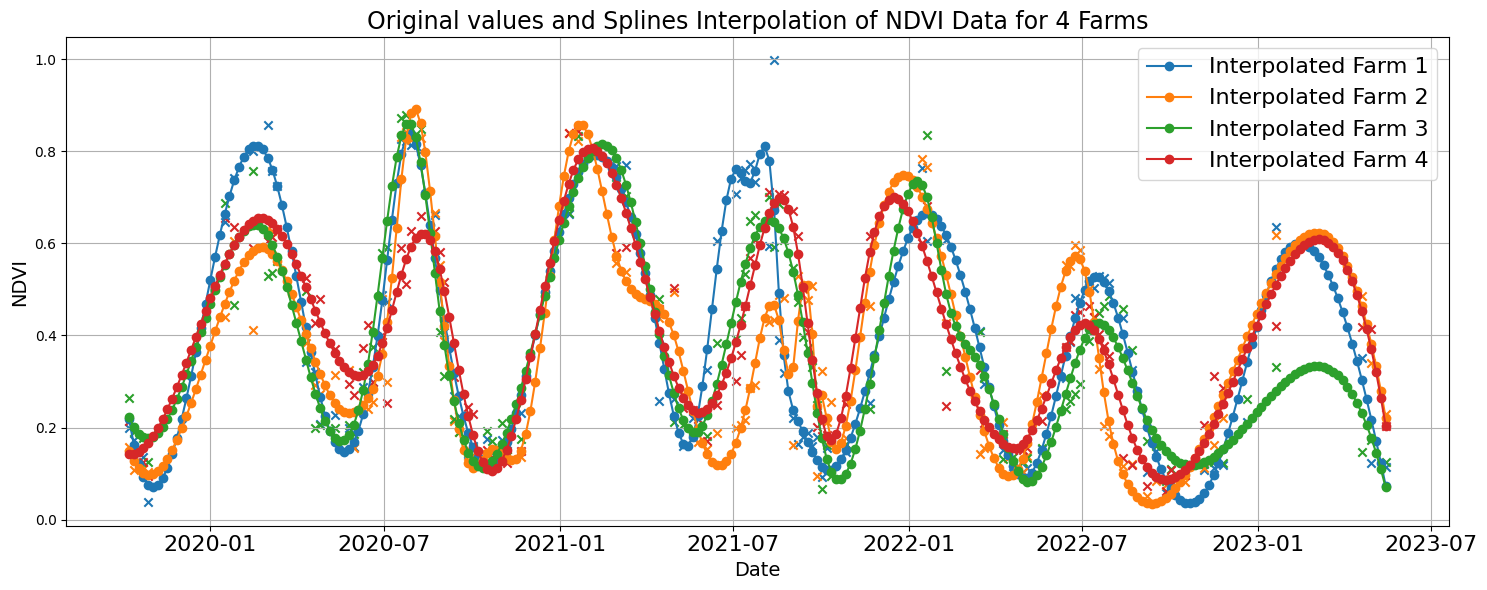

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression

# Load data for 5 farms
df_farm1 = pd.read_csv('/content/farm1.csv')
df_farm2 = pd.read_csv('/content/farm2.csv')
df_farm3 = pd.read_csv('/content/farm3.csv')
df_farm4 = pd.read_csv('/content/farm4.csv')


# # Define the start and end date for the time window
# start_date = '08-22-2021'
# end_date = '10-06-2022'

start_date = '10-01-2019'
end_date = '06-01-2023'

farm_dataframes = [df_farm1, df_farm2, df_farm3, df_farm4]

# Convert the "Date" column to datetime for all farms
for i in range(4):
    farm_dataframes[i]["Date"] = pd.to_datetime(farm_dataframes[i]["system:time_start"])

# Filter data within the specified date range
for i in range(4):
    farm_dataframes[i] = farm_dataframes[i][(farm_dataframes[i]["Date"] >= start_date) & (farm_dataframes[i]["Date"] <= end_date)]


# Generate a unique date range based on the intersection of date ranges for all farms
start_date = max(df["Date"].min() for df in farm_dataframes)
end_date = min(df["Date"].max() for df in farm_dataframes)
date_range = pd.date_range(start=start_date, end=end_date, freq="5D")

# Create lists to store interpolated values and trend data for all farms
interpolated_values = []
trend_data = []

for i in range(4):
    # Set the "Date" column as the index for each farm DataFrame
    farm_dataframes[i] = farm_dataframes[i].set_index("Date")

    # Resample the data to handle duplicate date labels (e.g., calculate the mean for duplicate dates)
    farm_dataframes[i] = farm_dataframes[i].resample("5D").mean()

    # Replace missing values with NaN for each farm
    farm_dataframes[i]["NDVI"] = farm_dataframes[i]["ndvi"].replace(0, np.nan)

    # Interpolate missing values using UnivariateSpline for different values of s
    x = np.arange(len(farm_dataframes[i]))
    mask = ~np.isnan(farm_dataframes[i]["NDVI"])
    s_values = [0.35]

    interpolated_values_farm = []

    for s in s_values:
        spline = UnivariateSpline(x[mask], farm_dataframes[i]["NDVI"][mask], k=3, s=s)
        interpolated_values_farm.append(spline(x))

    interpolated_values.append(interpolated_values_farm)

    # Reset the index and rename the columns for each farm
    farm_dataframes[i] = farm_dataframes[i].reset_index()
    farm_dataframes[i] = farm_dataframes[i].rename(columns={"index": "Date"})

    # Remove rows with missing values for each farm
    trend_data_farm = farm_dataframes[i].dropna()

    # Calculate the trend using linear regression for each farm
    X = trend_data_farm.index.values.reshape(-1, 1)
    y = trend_data_farm["NDVI"]
    model = LinearRegression()
    model.fit(X, y)
    trend = model.predict(X)

    trend_data.append(trend)

# Create a DataFrame with interpolated values and corresponding dates for all farms
interpolated_dfs = []
for i in range(4):
    interpolated_df = pd.DataFrame({"Date": farm_dataframes[i]["Date"], "NDVI": interpolated_values[i][0]})
    interpolated_dfs.append(interpolated_df)

# Save the interpolated DataFrames to CSV files for each farm
for i in range(4):
    interpolated_dfs[i].to_csv(f"/content/interpolated_data_farm{i+1}.csv", index=False)

# Plot the original data, interpolated values, and trend for all 5 farms----15*6 org----6*8 para date
plt.figure(figsize=(15,6))

# Plot original data for all farms
for i in range(4):
    plt.scatter(farm_dataframes[i]["Date"], farm_dataframes[i]["NDVI"], marker="x")

# Plot interpolated values for all farms
for i in range(4):
    plt.plot(farm_dataframes[i]["Date"], interpolated_values[i][0][:len(farm_dataframes[i])], "o-", label=f"Interpolated Farm {i + 1}")

# # Plot trend data for all farms
#for i in range(5):
  # plt.plot(farm_dataframes[i]["Date"], trend_data[i], label=f"Trend Farm {i + 1}")

plt.xlabel("Date",fontsize = 14)
plt.ylabel("NDVI",fontsize =14)
plt.title("Original values and Splines Interpolation of NDVI Data for 4 Farms",fontsize = 17)
plt.xticks(rotation=0,fontsize = 16)
plt.legend(prop={"size": 16})
plt.grid(True)
plt.tight_layout()
plt.show()
